In [1]:
import kagglehub
import os
# from typing import Literal

from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
# from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

import segmentation_models_pytorch as smp
from tqdm import tqdm

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {device}")

Device: mps


# Download latest version from kaggle

In [2]:
path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")
path = os.path.join(path, "Data")
print("Path to dataset files:", path)

Path to dataset files: /Users/dami/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1/Data


In [3]:
print(f"Number of samples in train set: {len(os.listdir(os.path.join(path, 'Train', 'image')))}")
print(f"Number of samples in test set : {len(os.listdir(os.path.join(path, 'Test', 'image')))}")

Number of samples in train set: 80
Number of samples in test set : 20


In [5]:
image: Image = Image.open(os.path.join(path, "Train", "image", "1.png"))
mask: Image = Image.open(os.path.join(path, "Train", "mask", "1.png"))

print(
    f"Images in dataset have size: {image.size} and are in {'GrayScale' if image.mode == 'L' else image.mode} mode, so have {len(image.getbands())} channels.")
print(
    f"Masks (target) in dataset have size: {mask.size} and are in {'GrayScale' if mask.mode == 'L' else mask.mode} mode, so have {len(mask.getbands())} channels.")

Images in dataset have size: (512, 512) and are in RGB mode, so have 3 channels.
Masks (target) in dataset have size: (512, 512) and are in GrayScale mode, so have 1 channels.


# Making custom dataset class

In [8]:

unet_size = 512


class ImageDataSet(Dataset):
    def __init__(self, directory_path: str = os.path.join(path, "Train"), n_samples : int=80, sample_transform=None,
                 target_transform=None):
        super(ImageDataSet, self).__init__()
        self.X_transform = sample_transform
        self.Y_transform = target_transform
        self.X = []
        self.Y = []

        for i in range(n_samples):
            try:
                image_path = os.path.join(directory_path, "image", f"{i}.png")
                mask_path = os.path.join(directory_path, "mask", f"{i}.png")
                image = self._load_transform_(image_path, target=False)
                mask = self._load_transform_(mask_path, target=True)
            except Exception as e:
                print(e)
                continue
            self.X.append(image)
            self.Y.append(mask)
        self.X = torch.stack(self.X)
        self.Y = torch.stack(self.Y)

    def _load_transform_(self, path, target=False):
        image = np.array(Image.open(path))
        if not target:
            return self.X_transform(image) if self.X_transform else image
        else:
            return self.Y_transform(image) if self.Y_transform else image

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

    def __len__(self):
        return len(self.X)


class NormalizeToIndex():
    def __init__(self, treshold: float = 0.5):
        self.treshold = treshold

    def __call__(self, y: torch.Tensor):
        return torch.where(y > self.treshold, 1, 0)


str

# Searching for best treshold to making binary mask

In [28]:
# Making Dataset with non binary mask
train_dataset = ImageDataSet(
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
    ]))

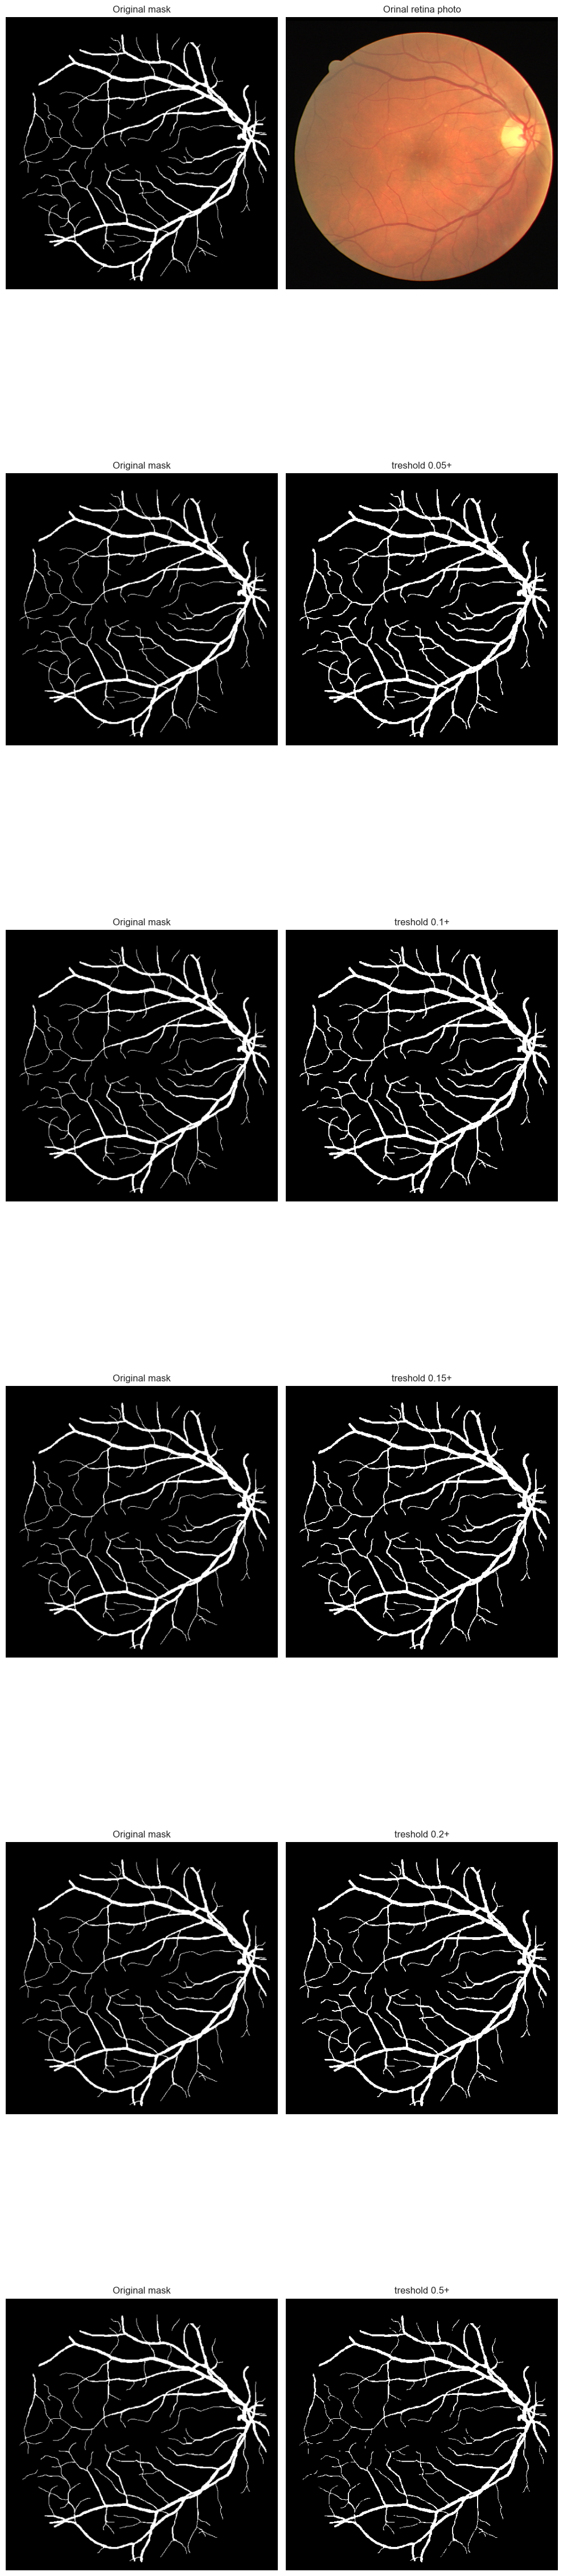

In [29]:
idx = 1
mask = train_dataset[idx][1].squeeze()
# c = a.__getitem__(1)[1].squeeze()
# resize = transforms.Resize([224])
# c = resize(torch.Tensor(c).unsqueeze(dim = 0)).squeeze()

fig, ax = plt.subplots(6, 2, figsize=(10, 50))
plt.gray()


for i in range(6):
    ax[i,0].imshow(mask)
    ax[i,0].set_title("Original mask")


ax[0,1].imshow(train_dataset[idx][0].permute(1, 2, 0))
ax[0,1].set_title("Orinal retina photo")
ax[1,1].imshow(mask > 0.05)
ax[1,1].set_title("treshold 0.05+")
ax[2,1].imshow(mask > 0.1)
ax[2,1].set_title("treshold 0.1+")
ax[3,1].imshow(mask > 0.15)
ax[3,1].set_title("treshold 0.15+")
ax[4,1].imshow(mask > 0.2)
ax[4,1].set_title("treshold 0.2+")
ax[5,1].imshow(mask > 0.5)
ax[5,1].set_title("treshold 0.5+")


[a.set_axis_off() for a in ax.ravel()]
plt.tight_layout()
plt.show()



So probably the best treshold will be 0.15.

# Making final datasets and dataloaders

In [30]:
# Making dataset with binary mask
train_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Train"),
    n_samples=80,
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15)
    ]))

test_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Test"),
    n_samples=20,
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15)
    ]))

In [31]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initializing unet model

In [14]:
unet = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
    # activation="sigmoid"
)
# sigmoid = nn.Sigmoid()

# Training

In [15]:
def train(model=unet,output_activation = sigmoid, train_loader=train_loader, val_loader=test_loader, lr=1e-3, EPOCHS=10):
    model.to(device)
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
    criterion = smp.losses.JaccardLoss(mode="binary", from_logits=True)  #this is IoU_loss

    iou_metric = MeanIoU(num_classes=2, input_format="index", include_background=False).to(device)
    dice_metric = DiceScore(num_classes=2, input_format="index", include_background=False).to(device)
    train_iou_scores = []
    eval_iou_scores = []
    train_dice_scores = []
    eval_dice_scores = []
    print("Start training:")
    for i in tqdm(range(EPOCHS)):
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()

            Y_pred = (output_activation(Y_pred) > 0.5).to(int)
            iou_metric.update(Y_pred, Y)
            dice_metric.update(Y_pred, Y)
        train_iou_scores.append(iou_metric.compute().item())
        train_dice_scores.append(dice_metric.compute().item())
        iou_metric.reset()
        dice_metric.reset()

        model.eval()
        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                Y_pred = (output_activation(model(X)) > 0.5).to(int)

                iou_metric.update(Y_pred, Y)
                dice_metric.update(Y_pred, Y)

            eval_iou_scores.append(iou_metric.compute().item())
            eval_dice_scores.append(dice_metric.compute().item())
            iou_metric.reset()
            dice_metric.reset()

        # I dont print loss, because score = 1 - loss, do it is the SAME
        print(
            f"Epoch: {str(i + 1).zfill(2)} | Train_IoU_score: {train_iou_scores[-1]:.4f}, Test_IoU_score: {eval_iou_scores[-1]:.4f} | Train_f1_score: {train_dice_scores[-1]:.4f}, Test_f1_score: {eval_dice_scores[-1]:.4f}")
    model.to("cpu")
    return train_iou_scores, train_dice_scores, eval_iou_scores, eval_dice_scores


train_iou_scores, train_f1_scores, eval_iou_scores, eval_f1_scores = train(EPOCHS=30)

Start training:


  3%|▎         | 1/30 [00:10<05:04, 10.50s/it]

Epoch: 01 | Train_IoU_score: 0.1868, Test_IoU_score: 0.1073 | Train_f1_score: 0.3088, Test_f1_score: 0.1997


  7%|▋         | 2/30 [00:18<04:20,  9.31s/it]

Epoch: 02 | Train_IoU_score: 0.3526, Test_IoU_score: 0.1011 | Train_f1_score: 0.5190, Test_f1_score: 0.1897


 10%|█         | 3/30 [00:27<04:00,  8.90s/it]

Epoch: 03 | Train_IoU_score: 0.4471, Test_IoU_score: 0.1368 | Train_f1_score: 0.6164, Test_f1_score: 0.2588


 13%|█▎        | 4/30 [00:35<03:47,  8.74s/it]

Epoch: 04 | Train_IoU_score: 0.5220, Test_IoU_score: 0.3678 | Train_f1_score: 0.6846, Test_f1_score: 0.5377


 17%|█▋        | 5/30 [00:44<03:37,  8.69s/it]

Epoch: 05 | Train_IoU_score: 0.5711, Test_IoU_score: 0.4843 | Train_f1_score: 0.7261, Test_f1_score: 0.6571


 20%|██        | 6/30 [00:53<03:27,  8.64s/it]

Epoch: 06 | Train_IoU_score: 0.5975, Test_IoU_score: 0.1695 | Train_f1_score: 0.7471, Test_f1_score: 0.3054


 23%|██▎       | 7/30 [01:01<03:18,  8.62s/it]

Epoch: 07 | Train_IoU_score: 0.6238, Test_IoU_score: 0.4854 | Train_f1_score: 0.7678, Test_f1_score: 0.6653


 27%|██▋       | 8/30 [01:09<03:07,  8.54s/it]

Epoch: 08 | Train_IoU_score: 0.6416, Test_IoU_score: 0.5906 | Train_f1_score: 0.7810, Test_f1_score: 0.7447


 30%|███       | 9/30 [01:18<02:58,  8.51s/it]

Epoch: 09 | Train_IoU_score: 0.6521, Test_IoU_score: 0.6489 | Train_f1_score: 0.7890, Test_f1_score: 0.7848


 33%|███▎      | 10/30 [01:26<02:49,  8.47s/it]

Epoch: 10 | Train_IoU_score: 0.6604, Test_IoU_score: 0.6070 | Train_f1_score: 0.7951, Test_f1_score: 0.7502


 37%|███▋      | 11/30 [01:35<02:40,  8.47s/it]

Epoch: 11 | Train_IoU_score: 0.6741, Test_IoU_score: 0.6571 | Train_f1_score: 0.8049, Test_f1_score: 0.7890


 40%|████      | 12/30 [01:43<02:32,  8.46s/it]

Epoch: 12 | Train_IoU_score: 0.6795, Test_IoU_score: 0.6602 | Train_f1_score: 0.8088, Test_f1_score: 0.7917


 43%|████▎     | 13/30 [01:52<02:24,  8.47s/it]

Epoch: 13 | Train_IoU_score: 0.6838, Test_IoU_score: 0.6774 | Train_f1_score: 0.8118, Test_f1_score: 0.8031


 47%|████▋     | 14/30 [02:00<02:15,  8.46s/it]

Epoch: 14 | Train_IoU_score: 0.6912, Test_IoU_score: 0.6249 | Train_f1_score: 0.8171, Test_f1_score: 0.7588


 50%|█████     | 15/30 [02:09<02:06,  8.43s/it]

Epoch: 15 | Train_IoU_score: 0.6979, Test_IoU_score: 0.6841 | Train_f1_score: 0.8218, Test_f1_score: 0.8102


 53%|█████▎    | 16/30 [02:17<01:57,  8.40s/it]

Epoch: 16 | Train_IoU_score: 0.7018, Test_IoU_score: 0.6874 | Train_f1_score: 0.8245, Test_f1_score: 0.8115


 57%|█████▋    | 17/30 [02:25<01:48,  8.37s/it]

Epoch: 17 | Train_IoU_score: 0.7053, Test_IoU_score: 0.6824 | Train_f1_score: 0.8269, Test_f1_score: 0.8045


 60%|██████    | 18/30 [02:33<01:40,  8.36s/it]

Epoch: 18 | Train_IoU_score: 0.7098, Test_IoU_score: 0.6899 | Train_f1_score: 0.8300, Test_f1_score: 0.8119


 63%|██████▎   | 19/30 [02:42<01:32,  8.38s/it]

Epoch: 19 | Train_IoU_score: 0.7157, Test_IoU_score: 0.6861 | Train_f1_score: 0.8340, Test_f1_score: 0.8109


 67%|██████▋   | 20/30 [02:50<01:23,  8.35s/it]

Epoch: 20 | Train_IoU_score: 0.7153, Test_IoU_score: 0.6836 | Train_f1_score: 0.8338, Test_f1_score: 0.8105


 70%|███████   | 21/30 [02:59<01:15,  8.35s/it]

Epoch: 21 | Train_IoU_score: 0.7174, Test_IoU_score: 0.6856 | Train_f1_score: 0.8353, Test_f1_score: 0.8090


 73%|███████▎  | 22/30 [03:07<01:06,  8.37s/it]

Epoch: 22 | Train_IoU_score: 0.7221, Test_IoU_score: 0.6875 | Train_f1_score: 0.8384, Test_f1_score: 0.8082


 77%|███████▋  | 23/30 [03:15<00:58,  8.37s/it]

Epoch: 23 | Train_IoU_score: 0.7282, Test_IoU_score: 0.6932 | Train_f1_score: 0.8425, Test_f1_score: 0.8151


 80%|████████  | 24/30 [03:24<00:50,  8.36s/it]

Epoch: 24 | Train_IoU_score: 0.7333, Test_IoU_score: 0.6952 | Train_f1_score: 0.8459, Test_f1_score: 0.8144


 83%|████████▎ | 25/30 [03:32<00:41,  8.35s/it]

Epoch: 25 | Train_IoU_score: 0.7344, Test_IoU_score: 0.6936 | Train_f1_score: 0.8466, Test_f1_score: 0.8154


 87%|████████▋ | 26/30 [03:40<00:33,  8.34s/it]

Epoch: 26 | Train_IoU_score: 0.7391, Test_IoU_score: 0.6955 | Train_f1_score: 0.8497, Test_f1_score: 0.8142


 90%|█████████ | 27/30 [03:49<00:25,  8.33s/it]

Epoch: 27 | Train_IoU_score: 0.7411, Test_IoU_score: 0.6945 | Train_f1_score: 0.8510, Test_f1_score: 0.8132


 93%|█████████▎| 28/30 [03:57<00:16,  8.33s/it]

Epoch: 28 | Train_IoU_score: 0.7408, Test_IoU_score: 0.6850 | Train_f1_score: 0.8508, Test_f1_score: 0.8096


 97%|█████████▋| 29/30 [04:05<00:08,  8.32s/it]

Epoch: 29 | Train_IoU_score: 0.7414, Test_IoU_score: 0.6807 | Train_f1_score: 0.8512, Test_f1_score: 0.7997


100%|██████████| 30/30 [04:14<00:00,  8.47s/it]

Epoch: 30 | Train_IoU_score: 0.7467, Test_IoU_score: 0.6917 | Train_f1_score: 0.8547, Test_f1_score: 0.8131


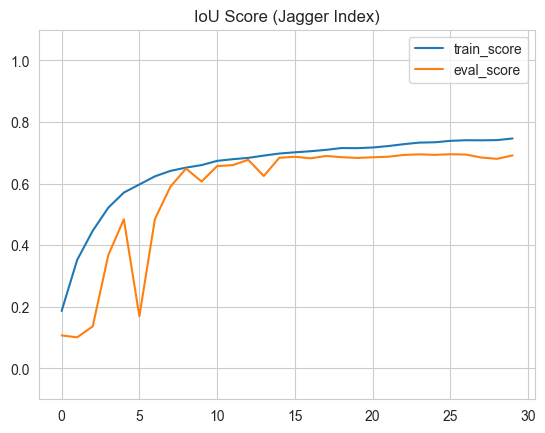

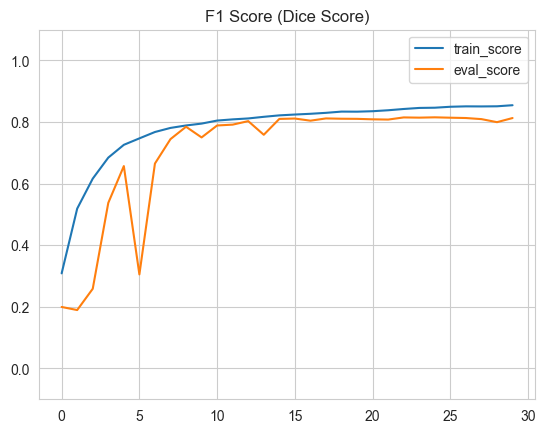

In [32]:
def plot_train_eval_scores(train_scores: list[float], eval_scores: list[float], title: str | None = None,
                           margin: float = 0.1):
    plt.plot(train_scores, label="train_score")
    plt.plot(eval_scores, label="eval_score")
    if title:
        plt.title(title)
    plt.ylim(0 - margin, 1 + margin)
    plt.legend()
    plt.show()


plot_train_eval_scores(train_iou_scores, eval_iou_scores, title="IoU Score (Jagger Index)")
plot_train_eval_scores(train_f1_scores, eval_f1_scores, title="F1 Score (Dice Score)")

In [33]:
print(f"Train IoU score: {train_iou_scores[-1]}")
print(f"Test  IoU score: {eval_iou_scores[-1]}")
print(f"Train F1  score: {train_f1_scores[-1]}")
print(f"Test  F1  score: {eval_f1_scores[-1]}")

Train IoU score: 0.7466787099838257
Test  IoU score: 0.6917068958282471
Train F1  score: 0.8547409176826477
Test  F1  score: 0.8131152987480164


# Checking results on example sample

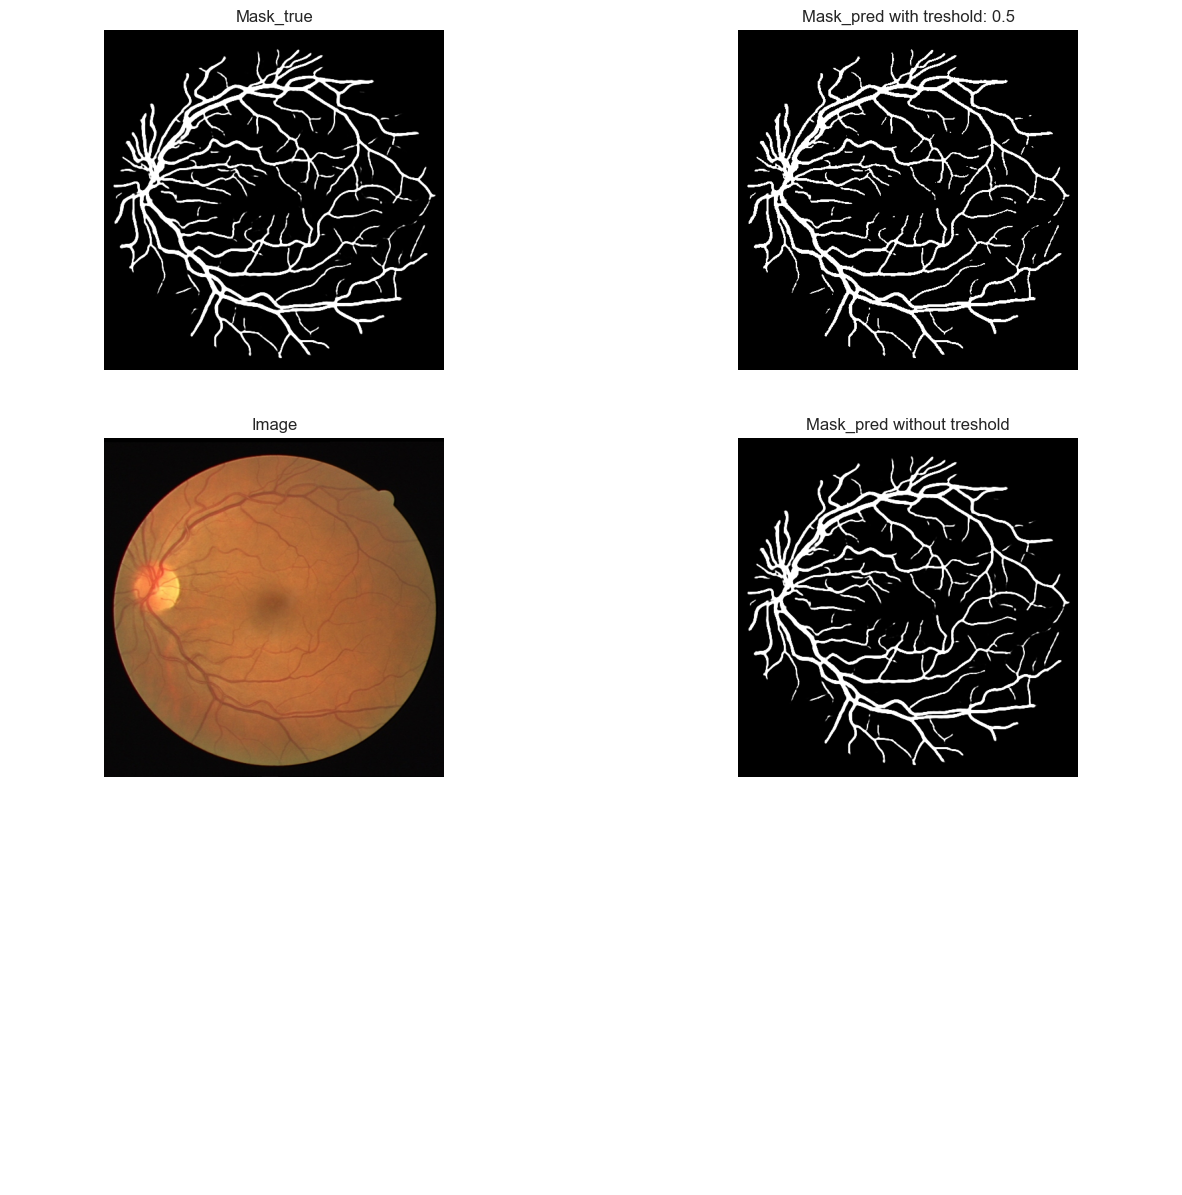

In [41]:
idx = 0  # number of sample
treshold = 0.5
unet.to("cpu")

with torch.no_grad():
    unet.eval()

    image = test_dataset[idx][0]
    mask_true = test_dataset[idx][1].squeeze()
    mask_pred = sigmoid(unet(image.unsqueeze(0)))
    mask_after_treshold = (mask_pred.squeeze() > treshold).int()
    image = image.permute(1, 2, 0)

    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    ax = ax.ravel()

    ax[0].imshow(mask.squeeze())
    ax[0].set_title("Mask_true")
    ax[1].imshow(mask_after_treshold)
    ax[1].set_title(f"Mask_pred with treshold: {treshold}")
    ax[2].imshow(image)
    ax[2].set_title("Image")
    ax[3].imshow(mask.squeeze())
    ax[3].set_title("Mask_pred without treshold")

    # TODO
    # ax[4].imshow()
    # ax[4].set_title("Combined mask_pred with mask_true")



    for a in ax:
        a.set_axis_off()
    # plt.tight_layout()
    plt.show()
